# Iceland Aerial Peprocessing

In [1]:
import hipp
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd

## Settings

In [2]:
# path settings
PROJECT_DIRECTORY = "data/iceland/aerial/1980_08_22"
RAW_IMAGES_DIRECTORY = os.path.join(PROJECT_DIRECTORY, "raw_images")
PREPROCESSED_IMAGES_DIRECTORY = os.path.join(PROJECT_DIRECTORY, "preprocessed_images")

# others settings
QUICKVIEWS_FACTOR = 0.2
MAX_WORKERS = 8

## Downloading the dataset

In [3]:
if not os.path.exists(RAW_IMAGES_DIRECTORY):
    !wget -c -r -np -nd -A "*.tif" -P {RAW_IMAGES_DIRECTORY} https://ftp.lmi.is/.stm/joaquin/history/iceland/aerial_images/19800822/raw_images/
    hipp.tools.generate_quickviews(RAW_IMAGES_DIRECTORY, QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)
else:
    print(f"{RAW_IMAGES_DIRECTORY} already exists, skipping download.")

data/iceland/aerial/1980_08_22/raw_images already exists, skipping download.


## Step 0 : Creation of an instance of the class `hipp.AerialPreprocessing`

In [3]:
ap = hipp.AerialPreprocessing(RAW_IMAGES_DIRECTORY, PREPROCESSED_IMAGES_DIRECTORY)

## Step 1 : Creation of corner fiducial template

- Choose an example image from the downloaded set (by default the first image will be used)
- `AerialPreprocessing.create_fiducial_template()`
    - will launch an `opencv2` window to interactively select the corner fiducial marker center (with `Ctrl + Click`).
    - will enhance the resolution of the template for matching at subpixel accuracy.
    - will launch an other `opencv2` window of the enhanced template to select the exact center of the fiducial. The matching routine implemented below first performs a coarse template matching, then refines the position using the subpixel template.

**Note** :
For reproducibility, `AerialPreprocessing.create_fiducial_template()` returns:
- The coarse coordinate of the fiducial.
- The subpixel-refined coordinate of the fiducial center.

If you already have these coordinates (e.g., saved from a previous run), you can pass them to the function to skip manual clicks entirely.


In [5]:
corner_coords = {'fiducial_coordinate': (1413, 676), 'subpixel_center_coordinate': (566, 566)}
_ = ap.create_fiducial_template(distance_around_fiducial=70,**corner_coords,  corner=True)

Before starting the next step make sure to have correct fiducials templates.

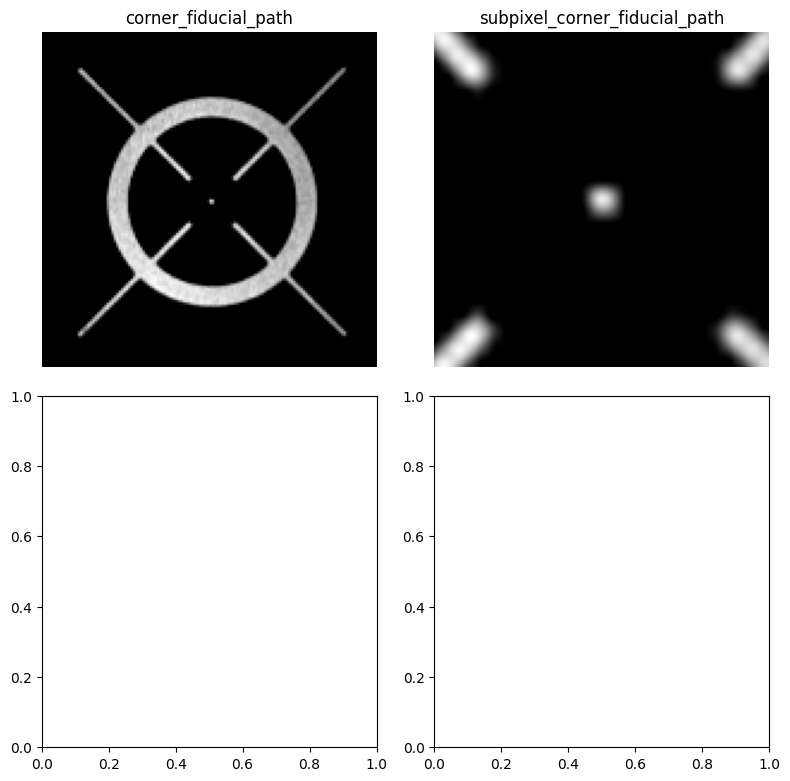

In [6]:
ap.plot_fiducial_templates()

## Step 3 : fiducials detection

The `AerialPreprocessing.detect_fiducials()` method will detect for all images in the raw images directory, midside fiducials and/or corner fiducials. The method will also save so qc plot to control detections. To work, the method will call for each raw image the function `hipp.aerial.core.detect_fiducials` wich perform the following steps:
- grid the image into a n x n blocks (where n is the parameters `grid_size`).
- if both corner_fiducial and supixel_corner_fiducial exists:
    - perform coarse template matching on the 4 corner blocks
    - refine the position using the supixel_corner_fiducial
- if both midside_fiducial and supixel_midside_fiducial exists:
    - perform coarse template matching on the 4 midside blocks
    - refine the position using the supixel_corner_fiducial
- compute principal point using all detected fiducials

**Note** : 
- this method use multi-threading
- the `grid_size` need to be an **odd number**, and should be chosen such that all fiducials fall within the expected grid layout for accurate detection.

100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


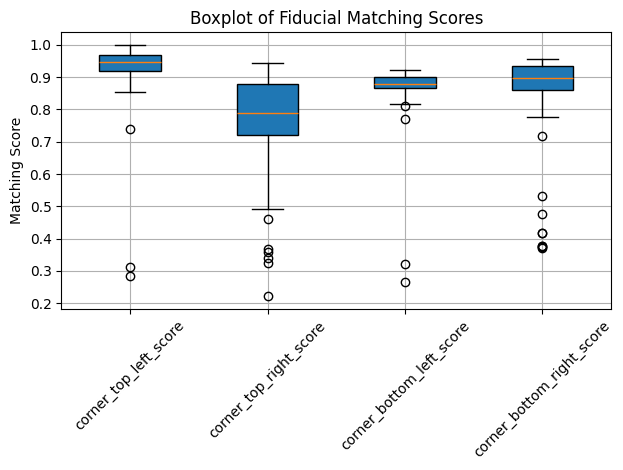

<Figure size 640x480 with 0 Axes>

In [4]:
detected_fiducials_df = ap.detect_fiducials(grid_size=7, max_workers=MAX_WORKERS)

as we can see on this qc plots the detection seems to be correct cause the distributions of matching score are close from 1. But we observe also some outliers. That can be cause of some miss detection caused by noise on images. You can check what are been detected for the outliers by looking the individuals qc plots.

## Step 4 : Outlier removal

Filters out false positives based on two criteria:

- **Geometric Consistency:** Calculates angles between fiducials, validating those close to 90°, assuming a square fiducial pattern.
- **Matching Score Thresholding:** Compares the score of each match to the median score and keeps only those with a certain threshold 

After filtering:
- The principal point is recalculated using valid diagonal and adjacent fiducials.
- For adjacent fiducials: the midpoint of the segment is computed, and a perpendicular offset is applied based on half the segment length.
- For diagonal fiducials: the midpoint of the segment is used directly.

/home/godinlu/miniconda3/envs/history/lib/python3.11/site-packages/hipp/aerial/aerial_preprocessing.py:252: UserWarning: Principal point could not be computed for 3 detection(s): ['F-9414.tif', 'F-9426.tif', 'F-9458.tif']
  warnings.warn(


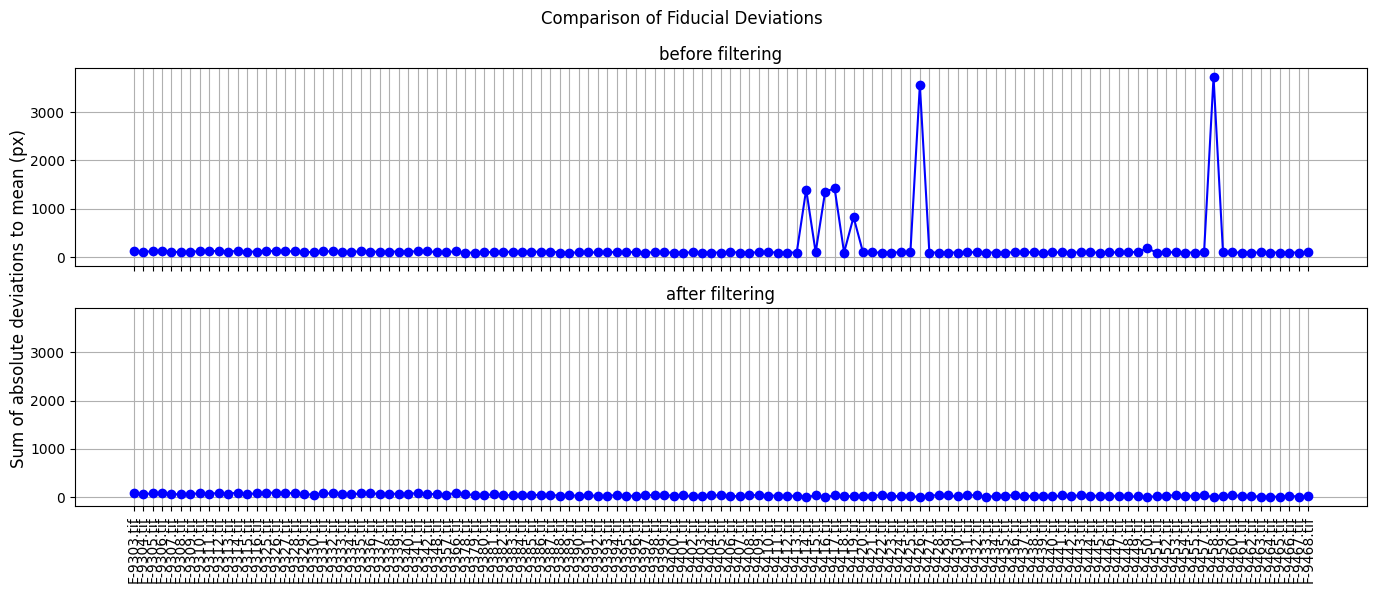

In [5]:
filtered_detected_fiducials_df = ap.filter_detected_fiducials(detected_fiducials_df)

As we can see on those qc plots, outliers seems to be correctly removed and we now have a decent deviation beetween detected fiducials coordinates.

But the function give us a user warning to tell us that for 3 images the principal point can't be computed.
We can look the detection qc plot to see what append.

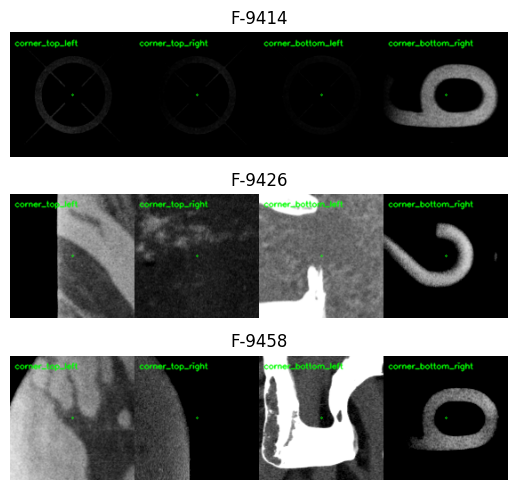

In [6]:
outlier_ids = ['F-9414', 'F-9426', 'F-9458']

outliers_quickviews = [os.path.join(ap.qc_directory, "fiducial_detections",f"{id}.png" ) for id in outlier_ids]

fig, axes = plt.subplots(3, 1, figsize=(15, 5))

for i, quickview_path in enumerate(outliers_quickviews):
    img = cv2.imread(quickview_path)
    axes[i].imshow(img)
    axes[i].axis('off') 
    axes[i].set_title(outlier_ids[i])
plt.tight_layout()
plt.show()


As we can see, for F-9414, the corner_bottom_left fiducial might need to be removed because it is too eroded.
However, for the other two, no fiducials are detected at all, so we cannot apply a reliable transformation to restore the image accurately.
At minimum, we still want to crop the image, so for the principal points, we will use the median coordinates calculated from the other detected principal points.

In [7]:
pp_keys = ["principal_point_x", "principal_point_y"]

# restitute corner_bottom_left and compute the principal point with it
filtered_detected_fiducials_df.loc["F-9414.tif", ["corner_bottom_left_x", "corner_bottom_left_y"]] = detected_fiducials_df.loc["F-9414.tif", ["corner_bottom_left_x", "corner_bottom_left_y"]]
filtered_detected_fiducials_df.loc["F-9414.tif", pp_keys] = hipp.aerial.fiducials.compute_principal_point(filtered_detected_fiducials_df.loc["F-9414.tif"])

# for ['F-9426.tif', 'F-9458.tif'] we will remove it from the df an preprocess it manually laters
filtered_detected_fiducials_df = filtered_detected_fiducials_df.drop(['F-9426.tif', 'F-9458.tif'])
filtered_detected_fiducials_df.to_csv(os.path.join(RAW_IMAGES_DIRECTORY, "detected_fiducial_markers.csv"))

As we can see on those qc plots, no outliers are found probably cause the detection is already perfect.

## Step 6 : Prepare calibrated (true) fiducial marker coordinates

- Extract calibrated fiducial marker coordinate information from [calibration report](data/aerial/calibration_report.pdf), obtained via entering Camera Number, Lens Number, and Focal Length (printed on image frame) at https://fsapps.nwcg.gov/afm/cam/cam.php
- Extract scanning resolution
- Create a csv file with a structure similare to [`camera_model_intrinsics.csv`](data/aerial/camera_model_intrinsics.csv). 
- Open the csv file with `hipp.aerial.open_camera_model_intrinsics`.
- (Optional) Plot `true_fiducials_mm` to be sure your csv is correctly setup.

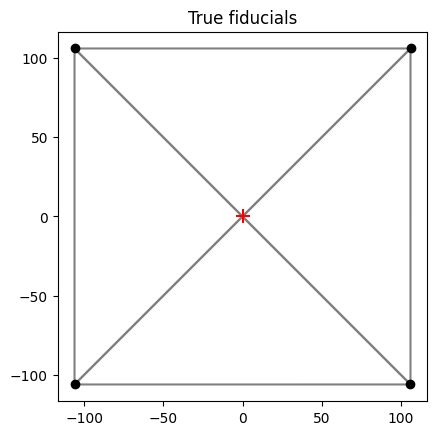

In [8]:
camera_model_path = os.path.join(PROJECT_DIRECTORY, "camera_model_intrinsics.csv")

scanning_resolution_mm, true_fiducials_mm = hipp.aerial.open_camera_model_intrinsics(camera_model_path)

hipp.aerial.plot_true_fiducials(true_fiducials_mm)

## Step 7 : Image restitution

The `AerialPreprocessing.images_restitution` method will preprocess all images in the raw image directory. It also generate a qc plot of the RMSE of the coordinate between true fiducials and detected fiducials before and after the transformation. To work, this method will call for each images the function `hipp.aerial.core.image_restitution` wich will peforms the following steps:
- convert the `true_fiducials_mm` in pixels ( / scanning_resolution_mm)
- translate `true_fiducials_pixels` with the computed principal point
- compute the appropriate geometric transformation to align true fiducials with detected fiducials based on the number of valid detected fiducials:
    - 1 point: Translation
    - 2 points: Similarity transformation
    - 3 or more points: Affine transformation
- transform the image with the computed transformation matrix and crop it with `image_square_dim`.
- Apply CLAHE enhancement

**Note** :
- The transformation matrix returned include the cropping. So if you apply those matrixs on detected fiducials coordinates, you will obtain detected fiducials coordinates of the final image.
- If `true_fiducials_mm` is `None` the first transformation is skipped.
- If `image_square_dim` is `None` the crop is skipped.
- This method use multi-processing to be faster.


Generating quickviews: 0image [00:00, ?image/s]


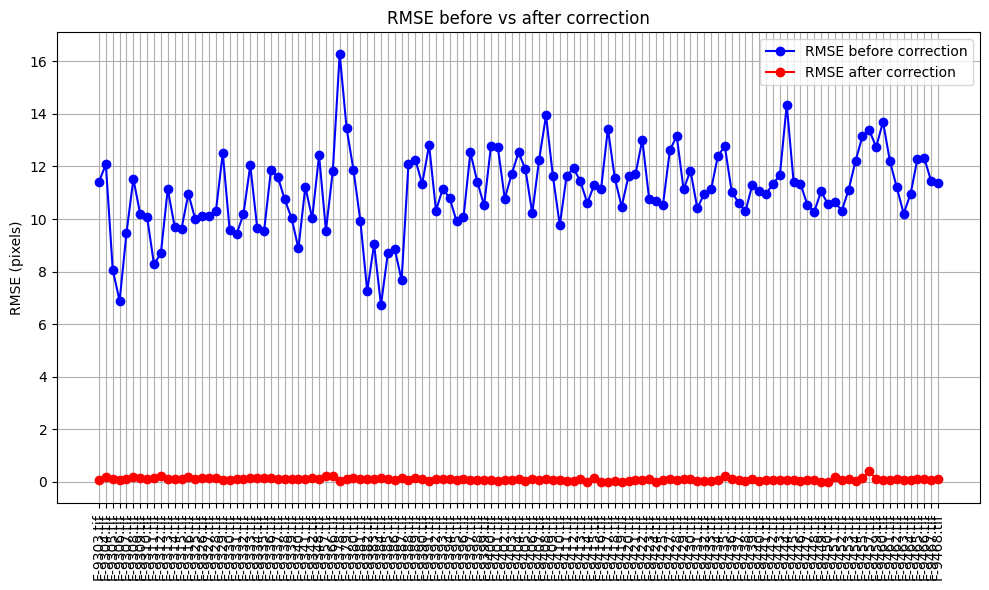

In [9]:
# here we take result image of 9 inchs (228.6 mm) because it's the size of aerial images
# we minus 5 px to be avoid some black borders
# can be apply with 208 mm to have no artifacts
image_square_dim = int(228.6 / scanning_resolution_mm) - 5 

transformation_matrixs = ap.images_restitution(
    filtered_detected_fiducials_df,
    true_fiducials_mm,
    image_square_dim=image_square_dim,
    scanning_resolution_mm=scanning_resolution_mm,
    max_workers=MAX_WORKERS,
    dry_run=True # set this to true if you don't want to process images
)

hipp.tools.generate_quickviews(PREPROCESSED_IMAGES_DIRECTORY, factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)

# apply previously computed transformation matrixs to detected fiducial coordinates, to
# have the detected fiducial coordinates of all restitute images.
transformed_detections = filtered_detected_fiducials_df.apply(lambda row: hipp.aerial.warp_fiducial_coordinates(row, transformation_matrixs[row.name]), axis=1)
transformed_detections.to_csv(os.path.join(PREPROCESSED_IMAGES_DIRECTORY, "detected_fiducial_markers.csv"))

## Step 8: Manually restore `F-9426.tif` and `F-9458.tif`

The corner fiducials of these two images are completely erased, making automatic detection impossible. To compensate, we will use **pseudofiducials**.

Since Hipp does not currently support pseudofiducial detection, this step must be performed manually:

- Manually click the four pseudofiducial markers for each of the two affected images.
- Repeat the same process on a **reference image** (an image where all corner fiducials are correctly detected).
- Apply the previously computed transformation for the reference image to its corresponding pseudofiducials.
- For each corrupted image, compute the transformation between its pseudofiducial coordinates and the transformed reference pseudofiducial coordinates.
- Apply this transformation to the target image, using a result window of size `image_square_dim`.

In [10]:
REF_IMAGE_ID = "F-9303.tif"
WRONG_IMAGES_ID = ["F-9426.tif", "F-9458.tif"]

PSEUDOFIDUCIAL_PATH = os.path.join(PROJECT_DIRECTORY, "pseudofiducials.csv")

In [11]:
def pick_midside_pseudofiducials(image_path: str, grid_size: int = 9) -> pd.Series:
    keys = {
        "midside_left":(grid_size//2, 0),
        "midside_top":(0, grid_size//2),
        "midside_right": (grid_size//2, grid_size-1),
        "midside_bottom": (grid_size-1, grid_size//2)
    }
    window_name = "point_pick"
    result = {"image_id":os.path.basename(image_path)}
    for key, value in keys.items():
        img, (offset_x, offset_y) = hipp.image.read_image_block_grayscale(image_path, *value, grid_shape=(grid_size, grid_size))
        coord = hipp.tools.pick_point_from_image(img, window_name)
        assert coord is not None
        result[key+"_x"],  result[key+"_y"] = coord[0] + offset_x, coord[1] + offset_y
    cv2.destroyWindow(window_name)

    return pd.Series(result) 

# clicking manually on each pseudo fiducials
if not os.path.exists(PSEUDOFIDUCIAL_PATH):
    series = [pick_midside_pseudofiducials(os.path.join(RAW_IMAGES_DIRECTORY, image_id)) for image_id in [REF_IMAGE_ID] + WRONG_IMAGES_ID]
    pd.DataFrame(series).set_index("image_id").to_csv(PSEUDOFIDUCIAL_PATH)
else:
    print(f"{PSEUDOFIDUCIAL_PATH} already exists, skipping points picking.")

data/iceland/aerial/1980_08_22/pseudofiducials.csv already exists, skipping points picking.


In [12]:
df = pd.read_csv(os.path.join(PROJECT_DIRECTORY, "pseudofiducials.csv"), index_col="image_id")
ref_pseudofiducials = hipp.aerial.warp_fiducial_coordinates(df.loc[REF_IMAGE_ID], transformation_matrixs[REF_IMAGE_ID])

for image_id in WRONG_IMAGES_ID:
    transformation_matrixs[image_id] = hipp.aerial.fiducials.compute_transformation(df.loc[image_id], ref_pseudofiducials)


    # apply the transformation
    image = cv2.imread(os.path.join(RAW_IMAGES_DIRECTORY, image_id), cv2.IMREAD_GRAYSCALE)
    output_image = cv2.warpAffine(image, transformation_matrixs[image_id][:2], dsize=(image_square_dim, image_square_dim), flags=cv2.INTER_CUBIC)
    output_image = hipp.image.apply_clahe(output_image)
    cv2.imwrite(os.path.join(PREPROCESSED_IMAGES_DIRECTORY, image_id), output_image)
    
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES_DIRECTORY, factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)

/home/godinlu/miniconda3/envs/history/lib/python3.11/site-packages/hipp/aerial/fiducials.py:187: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-74.23954376128984' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fiducials[x_key] = x_t
Generating quickviews: 0image [00:00, ?image/s]


In [14]:
import json
with open("tf_matrix_iceland.json", "w") as f:
    data = {key : value.tolist() for key, value in transformation_matrixs.items()}
    json.dump(data, f)

In [ ]:
import json 
import numpy as np
with open("tf_matrix_iceland.json", "r") as f:
    data = json.load(f)
transformation_matrixs = {key: np.array(value) for key, value in data.items()}

{'F-9303.tif': array([[ 1.00037181e+00, -2.18675469e-03, -1.00052063e+03],
        [ 2.05348226e-03,  1.00038950e+00, -2.67254174e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 'F-9304.tif': array([[ 1.00041258e+00, -2.32252138e-03, -1.00198766e+03],
        [ 2.16564661e-03,  1.00037126e+00, -2.67905150e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 'F-9305.tif': array([[ 1.00045681e+00, -1.52603629e-03, -1.00902976e+03],
        [ 1.39272950e-03,  1.00040365e+00, -2.65903056e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 'F-9306.tif': array([[ 1.00045745e+00, -1.28999109e-03, -1.01543937e+03],
        [ 1.15667628e-03,  1.00040428e+00, -2.68326040e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 'F-9307.tif': array([[ 1.00045002e+00, -1.80339931e-03, -1.00733339e+03],
        [ 1.66420060e-03,  1.00041459e+00, -2.65794291e+02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 'F-9

In [15]:
from hipp.math import transform_coord


df = pd.read_csv(os.path.join(PROJECT_DIRECTORY, "gcp.csv"))

def apply_affine(row):
    transform = transformation_matrixs[row["image_file_name"]]
    x, y = transform_coord((row["x"], row["y"]), transform)
    return pd.Series({"x": x, "y": y})

df[["x", "y"]] = df.apply(apply_affine, axis=1).round(2)
df.to_csv(os.path.join(PREPROCESSED_IMAGES_DIRECTORY, "gcp.csv"), index=False)

In [17]:
# here we take result image of 9 inchs (228.6 mm) because it's the size of aerial images
# we minus 5 px to be avoid some black borders
# can be apply with 208 mm to have no artifacts
image_square_dim = int(228.6 / scanning_resolution_mm) - 5 
ap.output_directory = os.path.join(PROJECT_DIRECTORY, "cropped_images")

transformation_matrixs = ap.images_restitution(
    filtered_detected_fiducials_df,
    None,
    image_square_dim=image_square_dim,
    scanning_resolution_mm=scanning_resolution_mm,
    max_workers=MAX_WORKERS,
    dry_run=False, # set this to true if you don't want to process images
    quality_control=False
)

hipp.tools.generate_quickviews(ap.output_directory, factor=QUICKVIEWS_FACTOR, max_workers=MAX_WORKERS)

# apply previously computed transformation matrixs to detected fiducial coordinates, to
# have the detected fiducial coordinates of all restitute images.
transformed_detections = filtered_detected_fiducials_df.apply(lambda row: hipp.aerial.warp_fiducial_coordinates(row, transformation_matrixs[row.name]), axis=1)
transformed_detections.to_csv(os.path.join(ap.output_directory, "detected_fiducial_markers.csv"))

Images restitution:  66%|██████▌   | 81/123 [00:52<00:41,  1.02image/s][ WARN:0@522.017] global grfmt_tiff.cpp:1381 writeLibTiff OpenCV TIFF(line 1381): failed TIFFWriteScanline(tif, buffer, y, 0) == 1
[ WARN:0@522.017] global grfmt_tiff.cpp:1381 writeLibTiff OpenCV TIFF(line 1381): failed TIFFWriteScanline(tif, buffer, y, 0) == 1
[ WARN:0@522.017] global grfmt_tiff.cpp:1381 writeLibTiff OpenCV TIFF(line 1381): failed TIFFWriteScanline(tif, buffer, y, 0) == 1
[ WARN:0@522.017] global grfmt_tiff.cpp:1381 writeLibTiff OpenCV TIFF(line 1381): failed TIFFWriteScanline(tif, buffer, y, 0) == 1
[ WARN:0@522.017] global grfmt_tiff.cpp:1381 writeLibTiff OpenCV TIFF(line 1381): failed TIFFWriteScanline(tif, buffer, y, 0) == 1
[ERROR:0@522.034] global loadsave.cpp:912 imwrite_ imwrite_('data/iceland/aerial/1980_08_22/cropped_images/F-9427.tif'): can't write data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_tiff.cpp:1381: error: (-2:Unspecified error) OpenCV TIFF: failed TIFFWriteScanlin

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9424.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9424.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9424.jpg']' returned non-zero exit status 1.


Generating quickviews:  10%|█         | 9/86 [00:00<00:05, 15.29image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9405.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9405.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9405.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9404.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9404.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9404.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9313.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9313.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9313.jpg']' returned non-zer

Generating quickviews:  20%|█▉        | 17/86 [00:01<00:04, 16.63image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9338.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9338.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9338.jpg']' returned non-zero exit status 1.[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9401.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9401.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9401.jpg']' returned non-zero exit status 1.

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9382.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9382.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9382.jpg']' returned non-zer

Generating quickviews:  23%|██▎       | 20/86 [00:01<00:05, 11.63image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9304.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9304.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9304.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9393.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9393.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9393.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9357.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9357.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9357.jpg']' returned non-zer

Generating quickviews:  34%|███▎      | 29/86 [00:02<00:03, 17.87image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9327.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9327.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9327.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9429.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9429.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9429.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9416.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9416.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9416.jpg']' returned non-zer

Generating quickviews:  37%|███▋      | 32/86 [00:02<00:03, 14.62image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9410.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9410.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9410.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9331.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9331.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9331.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9399.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9399.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9399.jpg']' returned non-zer

Generating quickviews:  41%|████      | 35/86 [00:02<00:03, 15.49image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9398.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9398.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9398.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9419.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9419.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9419.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9337.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9337.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9337.jpg']' returned non-zer

Generating quickviews:  45%|████▌     | 39/86 [00:02<00:03, 14.93image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9378.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9378.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9378.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9411.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9411.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9411.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9307.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9307.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9307.jpg']' returned non-zer

Generating quickviews:  48%|████▊     | 41/86 [00:03<00:03, 13.29image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9325.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9325.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9325.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9395.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9395.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9395.jpg']' returned non-zero exit status 1.


Generating quickviews:  50%|█████     | 43/86 [00:03<00:03, 12.22image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9406.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9406.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9406.jpg']' returned non-zero exit status 1.


Generating quickviews:  52%|█████▏    | 45/86 [00:03<00:05,  7.99image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9305.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9305.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9305.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9309.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9309.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9309.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9402.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9402.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9402.jpg']' returned non-zer

Generating quickviews:  57%|█████▋    | 49/86 [00:04<00:03,  9.26image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9329.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9329.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9329.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9311.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9311.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9311.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9413.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9413.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9413.jpg']' returned non-zer

Generating quickviews:  60%|██████    | 52/86 [00:04<00:02, 12.30image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9341.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9341.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9341.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9421.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9421.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9421.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9384.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9384.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9384.jpg']' returned non-zer

Generating quickviews:  66%|██████▋   | 57/86 [00:04<00:01, 15.01image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9425.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9425.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9425.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9396.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9396.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9396.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9328.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9328.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9328.jpg']' returned non-zer

Generating quickviews:  72%|███████▏  | 62/86 [00:04<00:01, 18.28image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9414.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9414.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9414.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9417.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9417.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9417.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9408.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9408.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9408.jpg']' returned non-zer

Generating quickviews:  76%|███████▌  | 65/86 [00:04<00:01, 14.48image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9379.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9379.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9379.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9315.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9315.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9315.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9326.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9326.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9326.jpg']' returned non-zer

Generating quickviews:  81%|████████▏ | 70/86 [00:05<00:00, 16.47image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9303.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9303.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9303.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9415.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9415.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9415.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9385.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9385.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9385.jpg']' returned non-zer

Generating quickviews:  84%|████████▎ | 72/86 [00:05<00:01, 13.53image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9334.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9334.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9334.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9339.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9339.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9339.jpg']' returned non-zero exit status 1.


Generating quickviews:  92%|█████████▏| 79/86 [00:05<00:00, 19.57image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9409.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9409.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9409.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9381.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9381.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9381.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9422.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9422.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9422.jpg']' returned non-zer

Generating quickviews:  95%|█████████▌| 82/86 [00:05<00:00, 16.41image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9420.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9420.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9420.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9310.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9310.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9310.jpg']' returned non-zero exit status 1.


Generating quickviews: 100%|██████████| 86/86 [00:06<00:00, 13.82image/s]

[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9397.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9397.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9397.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9335.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9335.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9335.jpg']' returned non-zero exit status 1.
[ERROR] Failed to process data/iceland/aerial/1980_08_22/cropped_images/F-9314.tif: Command '['gdal_translate', '-of', 'JPEG', '-co', 'QUALITY=85', '-outsize', '20%', '20%', 'data/iceland/aerial/1980_08_22/cropped_images/F-9314.tif', 'data/iceland/aerial/1980_08_22/cropped_images/quickviews/F-9314.jpg']' returned non-zer